In [1]:
import huracanpy

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from tqdm import tqdm
import cartopy.crs as ccrs

In [2]:
flist = glob("SyCLoPS/SyCLoPS_classified*.parquet")
flist

['SyCLoPS/SyCLoPS_classified_JRA3Q.parquet',
 'SyCLoPS/SyCLoPS_classified_MERRA2.parquet',
 'SyCLoPS/SyCLoPS_classified_ERA5.parquet']

In [3]:
# List of available datasets
sources = [f.split("_")[-1].split(".")[0] for f in flist]
sources

['JRA3Q', 'MERRA2', 'ERA5']

In [4]:
# Path dict
filepaths = {sources[i]:flist[i] for i in range(len(flist))}

In [5]:
# Data dict
data = {}
for s in tqdm(sources):
    data[s] = huracanpy.load(filepaths[s], baselon = -180).rename({"tid":"track_id", "mslp":"pres", "ws":"wind10"})
    # Convert pressures to hPa
    data[s] = data[s].assign(pres = data[s].pres / 100)

100%|██████████| 3/3 [00:24<00:00,  8.23s/it]


## Sanity checks

In [6]:
# Check trackids
for s in sources:
    sample = np.random.choice(len(data[s].record), 3)
    sample_pts = data[s].sel(record = sample)
    print(s, sample_pts.track_id.values)

JRA3Q [406032 358898 483882]
MERRA2 [ 93534 173292 212043]
ERA5 [359465 284758 273363]


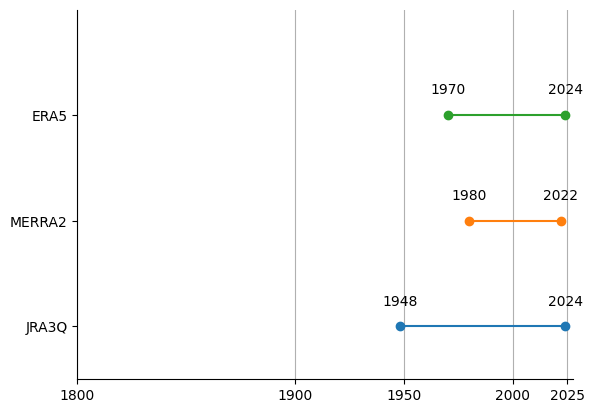

In [7]:
# Check durations
for i, s in enumerate(sources):
    Ymin, Ymax = data[s].time.dt.year.min().values, data[s].time.dt.year.max().values
    plt.plot([Ymin, Ymax], [i, i], marker = 'o')
    plt.text(Ymin, i+0.2, Ymin, horizontalalignment='center',)
    plt.text(Ymax, i+0.2, Ymax, horizontalalignment='center',)
plt.yticks(np.arange(len(sources)), sources)
plt.xticks([1800, 1900, 1950, 2000, 2025])
plt.ylim(-0.5, len(sources))
sns.despine()
plt.grid(axis = 'x')

Text(0, 0.5, '#tracks/year')

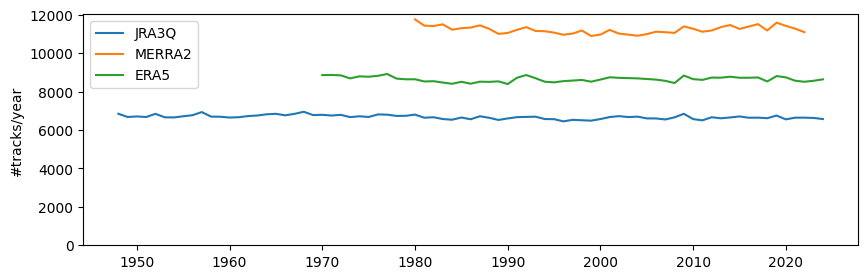

In [8]:
# Check Number of tracks per year
fig, axs = plt.subplots(figsize = (10,3))
for s in sources:
    Y = np.arange(1850, 2030)
    H, _ = np.histogram(data[s].hrcn.get_gen_vals().time.dt.year, bins = np.arange(1849.5, 2030))
    axs.plot(Y[H>0], H[H>0],label = s)
plt.legend()
plt.ylim(0)
plt.ylabel("#tracks/year")

In [9]:
help(sample_pts.hrcn.plot_density)

Help on method plot_density in module huracanpy._accessor:

plot_density(lon_name='lon', lat_name='lat', density_kws={}, **kwargs) method of huracanpy._accessor.HuracanPyDatasetAccessor instance



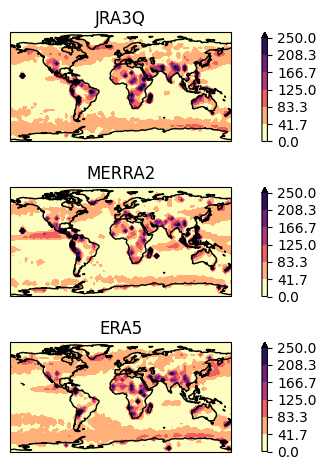

In [10]:
# Check geographical distribution
fig, axs = plt.subplots(len(sources), subplot_kw=dict(projection = ccrs.PlateCarree()))
for i, s in enumerate(sources):
    sample = np.random.choice(len(data[s].record), 100000)
    sample_pts = data[s].sel(record = sample)
    d = sample_pts.hrcn.get_density()
    d.plot.contourf(vmax = 250, vmin = 0, ax = axs[i], cmap = "magma_r")
    axs[i].coastlines()
    axs[i].set_title(s)
plt.tight_layout()

Text(0.5, 0, 'Latitude in °')

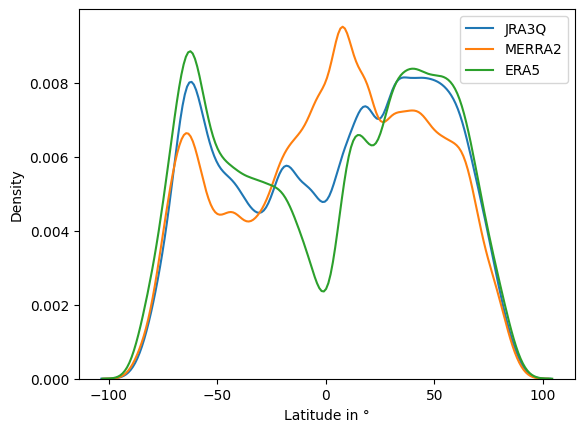

In [11]:
# Check latitude distribution
for s in sources:
    sample = np.random.choice(len(data[s].record), 100000)
    sample_pts = data[s].sel(record = sample)
    sns.kdeplot(sample_pts.lat, label = s)
plt.legend()
plt.xlabel("Latitude in °")

/tmp/ipykernel_553/2907107950.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


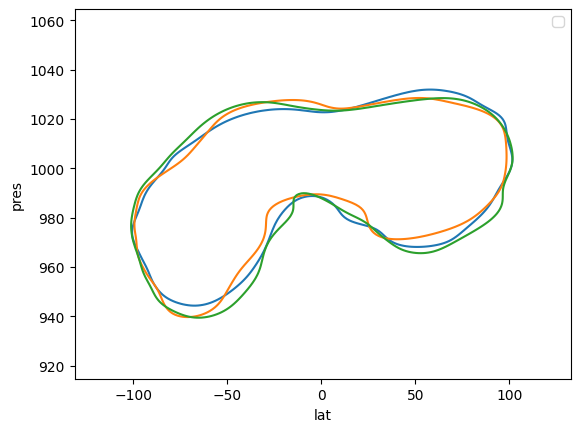

In [12]:
# Check psl values
for s in sources:
    sample = np.random.choice(len(data[s].record), 1000)
    sample_pts = data[s].sel(record = sample)
    sns.kdeplot(x=sample_pts.lat, y=sample_pts.pres, levels = 2, label = s)
plt.legend()

/tmp/ipykernel_553/323322730.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_553/323322730.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_553/323322730.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


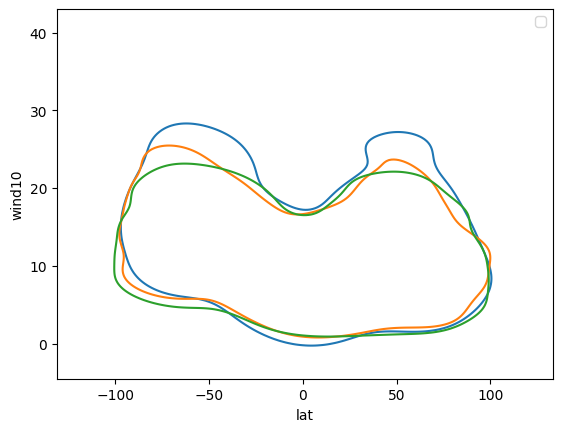

In [13]:
# Check wind values
for s in sources:
    sample = np.random.choice(len(data[s].record), 1000)
    sample_pts = data[s].sel(record = sample)
    sns.kdeplot(x=sample_pts.lat, y=sample_pts.wind10.where(sample_pts.wind10 <1e10), levels = 2,)
    plt.legend()

In [14]:
for s in tqdm(sources):
    data[s] = data[s].where(data[s].time.dt.hour % 6 == 0, drop = True)
    huracanpy.save(data[s], "SyCLoPS/SyCLoPS-"+s+".csv")

100%|██████████| 3/3 [04:11<00:00, 83.81s/it] 
